#Equipo 21 -
- Hinara Pastora Sanchez Mata
- Anna Ospina Bedoya
- Juan Jose Tobon

### Introducción a la inteligencia artificial 2024-01

## PREGUNTA 4

### NUMERAL A

Realice un ejemplo sencillo en Python usando las librerías que considere necesarias
en donde se ilustre la mayoría de los conceptos presentados anteriormente y cuyo
objetivo sea utilizar una CNN (de varias capas) para la clasificación de razas de gatos en
imágenes**. Cabe señalar que el tamaño mínimo del Dataset que ustedes proponen debe
ser de 3.000 registros.

* Para los gatos no basta solo con realizar un clasificador binario (es gato/ no es gato); el
clasificador debe poder discernir entre al menos 5 tipos de razas de gatos (Por ejm.
Siamés, Maine con, Gato persa, Gato kohana, Gato británico de pelo corto ó British
shorthair, etc.).
* ** Asegúrese de que se pueda acceder a las imágenes desde el código para reentrenar
la red en el momento de la revisión del proyecto, ya sea que las tenga almacenadas en
alguna unidad compartida en Drive, que se tomen directamente desde algún sitio web o
librería de Python, o desde cualquier otro medio con el que trabaje.

## Importar librerías

In [32]:
# Importar bibliotecas necesarias
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## Cargar imágenes

Se realiza el proceso de carga de imágenes almacenadas en Google Drive para su uso en un modelo de clasificación. Primero, se monta Google Drive en Google Colab para acceder a los archivos almacenados en una carpeta específica dentro de una unidad compartida. A continuación, se define una función que carga las imágenes desde las subcarpetas de dicha carpeta, donde cada subcarpeta representa una clase de la clasificación. Esta función redimensiona las imágenes a un tamaño específico, las convierte a arreglos numéricos normalizados (escala 0-1) y les asigna etiquetas correspondientes a su clase. El conjunto de datos resultante incluye las imágenes, las etiquetas y los nombres de las clases, lo que permite posteriormente entrenar un modelo de red neuronal en esta información.

In [33]:
# Paso 1: Montar Google Drive en Colab
drive.mount('/content/drive')

# Paso 2: Definir la ruta a la carpeta dentro de la Unidad Compartida
ruta_carpeta_imagenes = '/content/drive/Shared drives/IA 2024-1/Trabajo 4/archive'

# Paso 3: Función para cargar las imágenes desde la carpeta en Google Drive
def cargar_img_drive(directorio: str, img_size: tuple[int, int], color_mode: str):
    """
    Carga las imágenes desde una carpeta de Google Drive y las etiqueta según las subcarpetas.

    Args:
        directorio (str): Ruta a la carpeta que contiene las imágenes organizadas en subcarpetas.
        img_size (tuple[int, int]): Tamaño al que redimensionar las imágenes.
        color_mode (str): Modo de color ('rgb' o 'grayscale').

    Returns:
        tuple: Un conjunto de datos con las imágenes (X), etiquetas (y) y los nombres de las clases.
    """
    X, y = [], []
    class_names = os.listdir(directorio)  # Lista de subcarpetas, cada una representando una clase
    for i, img_fold in enumerate(class_names):
        images_path = os.listdir(os.path.join(directorio, img_fold))  # Lista de archivos de imagen
        y.extend([i] * len(images_path))  # Etiquetas correspondientes a la clase actual
        for img_name in images_path:
            image_path = os.path.join(directorio, img_fold, img_name)
            image = tf.keras.utils.load_img(
                image_path,
                target_size=img_size,
                color_mode=color_mode
            )
            image = tf.keras.utils.img_to_array(image) / 255.0  # Normalización de las imágenes (escala 0-1)
            X.append(image)  # Añadir la imagen al conjunto de datos
    return np.array(X), np.array(y), class_names

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Dolphin', 'Crabs', 'Octopus', 'Squid', 'Sharks', 'Sea Rays', 'Starfish', 'Penguin', 'Otter']


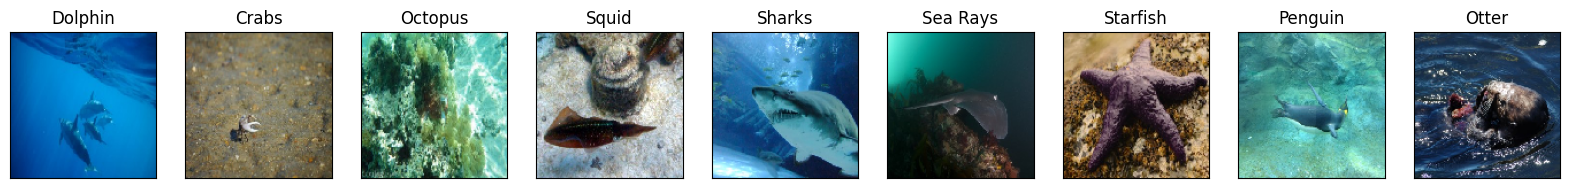

In [34]:
# Cargar imágenes desde Google Drive
X, y, class_names = cargar_img_drive(
    directorio=ruta_carpeta_imagenes,
    img_size=(128, 128),
    color_mode='rgb'
)
print(class_names)
# Definir las clases
clases = ['Dolphin', 'Crabs', 'Octopus', 'Squid', 'Sharks', 'Sea Rays', 'Starfish', 'Penguin', 'Otter']
# Crear subgráficas para mostrar una imagen por clase
_, axes = plt.subplots(1, len(clases), figsize=(20, 5))

for i in range(len(clases)):
    # Mostrar la primera imagen de cada clase
    axes[i].imshow(X[y == i][0])
    axes[i].set_title(clases[i])
    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()

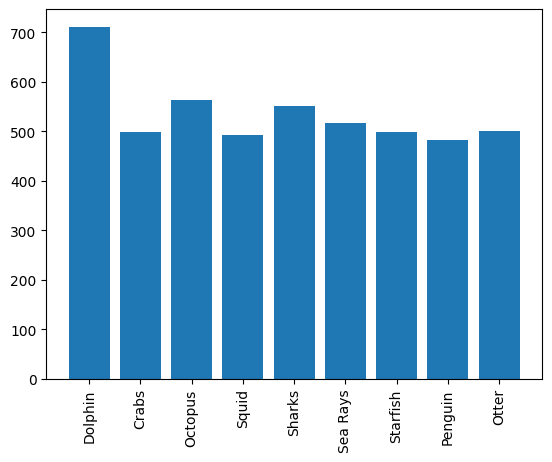

In [35]:
plt.figure()
plt.bar(clases, np.bincount(y))
plt.xticks(rotation=90)  # Rotar las etiquetas 90 grados
plt.show()

In [36]:
# Crear instancias de ImageDataGenerator para las distintas fases
train_datagen = ImageDataGenerator(
    rotation_range=40,            # Aumentación: rotación
    width_shift_range=0.2,        # Aumentación: desplazamiento horizontal
    height_shift_range=0.2,       # Aumentación: desplazamiento vertical
    shear_range=0.5,              # Aumentación: cizalla
    zoom_range=0.2,               # Aumentación: zoom
    validation_split= 0.2,
    horizontal_flip=True,         # Aumentación: inversión horizontal
    fill_mode='nearest'
)

## CNN

Se establecen los pasos necesarios para configurar y entrenar una red neuronal convolucional (CNN) para la clasificación de imágenes. Primero, se definen las dimensiones a las que se redimensionarán las imágenes y el modo de color. Luego, se cargan las imágenes y se dividen en conjuntos de entrenamiento y prueba con una proporción de 80/20. A continuación, se construye la arquitectura de la CNN, que incluye varias capas de convolución seguidas de capas de pooling para reducir la dimensionalidad, una capa de aplanamiento y una capa densa final para la clasificación. El modelo se compila utilizando el optimizador Adam y la pérdida de entropía cruzada categórica. Posteriormente, se entrena el modelo durante 10 épocas, validando su desempeño en el conjunto de prueba, y finalmente se guarda el modelo entrenado en Google Drive para su uso futuro.

In [37]:
# Paso 4: Definir el tamaño de la imagen y el modo de color
img_size = (128, 128)
color_mode = 'rgb'

# Normalizamos los datos
X_scaled = X.astype('float32') / 255.0

# Paso 6: Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Convertir las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

print(f"Forma de y_train después de one-hot encoding: {y_train.shape}")  # Ejemplo: (60000, 9)
print(f"Forma de y_test después de one-hot encoding: {y_test.shape}")    # Ejemplo: (10000, 9)

print(f"Imágenes cargadas: {X_scaled.shape[0]}")
print(f"Clases: {class_names}")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Paso 7: Definir la arquitectura de la red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    # Capa de convolución 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.BatchNormalization(),  # Añadir BatchNormalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Capa de convolución 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Añadir BatchNormalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Capa de convolución 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Añadir BatchNormalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Capa de convolución 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Añadir BatchNormalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Capa de aplanamiento
    tf.keras.layers.Flatten(),

    # Capa densa 1
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Añadir Dropout para regularización

    # Capa de salida (una neurona por cada clase)
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

Forma de y_train después de one-hot encoding: (3850, 9)
Forma de y_test después de one-hot encoding: (963, 9)
Imágenes cargadas: 4813
Clases: ['Dolphin', 'Crabs', 'Octopus', 'Squid', 'Sharks', 'Sea Rays', 'Starfish', 'Penguin', 'Otter']
Tamaño del conjunto de entrenamiento: 3850
Tamaño del conjunto de prueba: 963


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Definir los callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'model_best.keras',                # Guardar el mejor modelo
    save_best_only=True,               # Solo guarda si la métrica mejora
    monitor='val_accuracy',                # Métrica a monitorear
    mode='max',                        # Modo para la métrica (mínima pérdida)
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',            # Métrica de precisión de validación
    patience=5,                        # Número de épocas sin mejora antes de detener
    mode='max',                        # Modo de maximización de la métrica
    verbose=1,
    restore_best_weights=True          # Restaura el mejor modelo encontrado
)
# Lista de callbacks
callbacks = [
    checkpoint_cb,
    early_stopping_callback,
]

In [41]:
# Paso 8: Compilar el modelo después de definir los callbacks
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Aumentación de datos para el entrenamiento
train_data_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Entrenamiento del modelo con los callbacks
history = model.fit(
    train_data_augmenter.flow(X_train, y_train, subset="training"),
    validation_data=train_data_augmenter.flow(X_train, y_train, subset="validation"),
    epochs=30,
    callbacks=callbacks,
    batch_size=32,
    validation_batch_size=32
)

# Paso 10: Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nPrecisión en el conjunto de prueba: {test_acc}")

# Paso 11: Guardar el modelo entrenado
model.save('modelo_cnn_mejorado.keras')
print("Modelo mejorado guardado en el formato más actual de Keras.")

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3341 - loss: 1.8974
Epoch 1: val_accuracy improved from -inf to 0.07273, saving model to model_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3341 - loss: 1.8974 - val_accuracy: 0.0727 - val_loss: 11.1295
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3396 - loss: 1.8538
Epoch 2: val_accuracy improved from 0.07273 to 0.07403, saving model to model_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3395 - loss: 1.8535 - val_accuracy: 0.0740 - val_loss: 22.6459
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3645 - loss: 1.7041
Epoch 3: val_accuracy improved from 0.07403 to 0.12987, saving model to model_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.3646 - loss: 1.7041 - val_accuracy: 0.1299 - val_loss: 9.6486
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3762 - loss: 1.6414
Epoch 4: val_accuracy did not improve from 0.12987
97/

### NUMERAL B

Realice un mapa de características (feature map) de las primeras 3 capas
convolucionales de la CNN diseñada y explique qué patrones observa y considera usted
que aprende cada capa convolucional y su influencia en la representación de la
información.

In [ ]:
model.summary()
print(globals().keys())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,818,589 (29.83 MB)

 Trainable params: 2,605,961 (9.94 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 5,211,924 (19.88 MB)

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'os', 'np', 'tf', 'drive', 'train_test_split', 'plt', 'classification_report', 'confusion_matrix', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'sns', 'Model', 'img_to_array', 'load_img', 'ImageDataGenerator', 'to_categorical', '_i2', 'ruta_carpeta_imagenes', 'cargar_img_drive', '_i3', '_i4', '_i5', '_i6', 'X', 'y', 'class_names', 'clases', 'axes', 'i', '_i7', '_7', '_i8', '_i9', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', 'train_datagen', '_i16', 'img_size', 'color_mode', 'X_scaled', 'X_train', 'X_test', 'y_train', 'y_test', 'model', '_i17', 'checkpoint_cb', 'early_stopping_callback', 'reduce_lr_callback', 'callbacks', '_i18', 'train_data_augmenter', '_i19', '_i20', '_i21', '_i22', '_i23', '_i24', 'history', 'test_loss', 'test_acc', '_i25'])


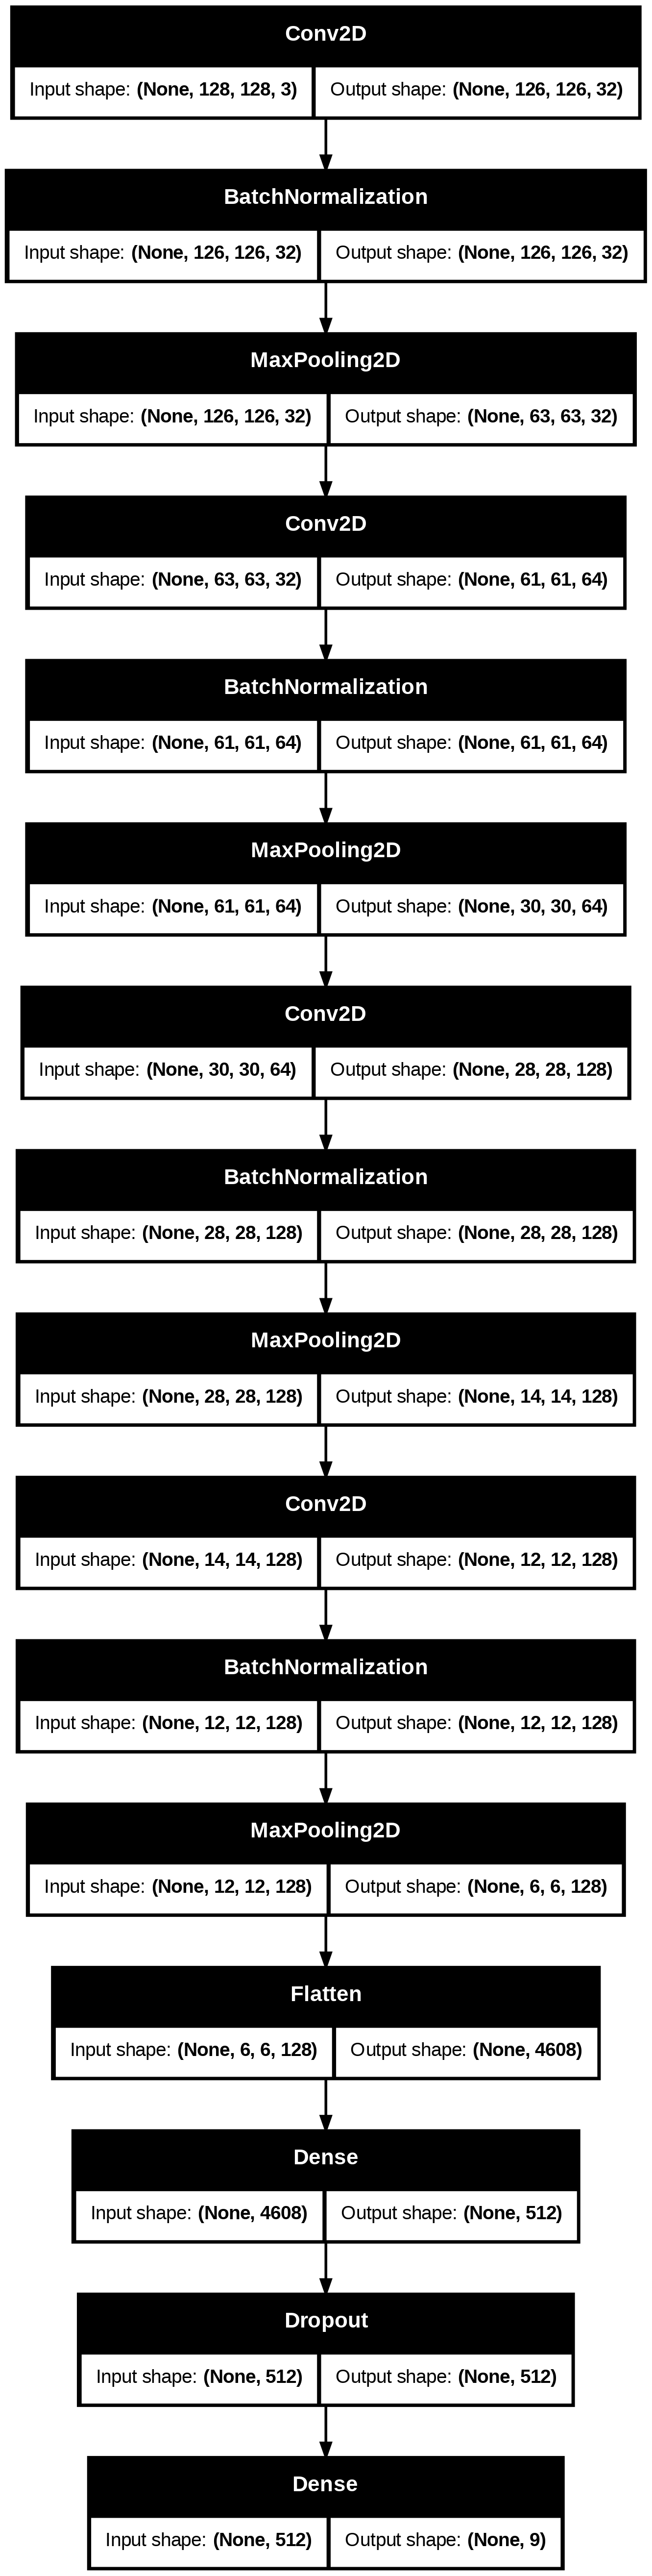

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


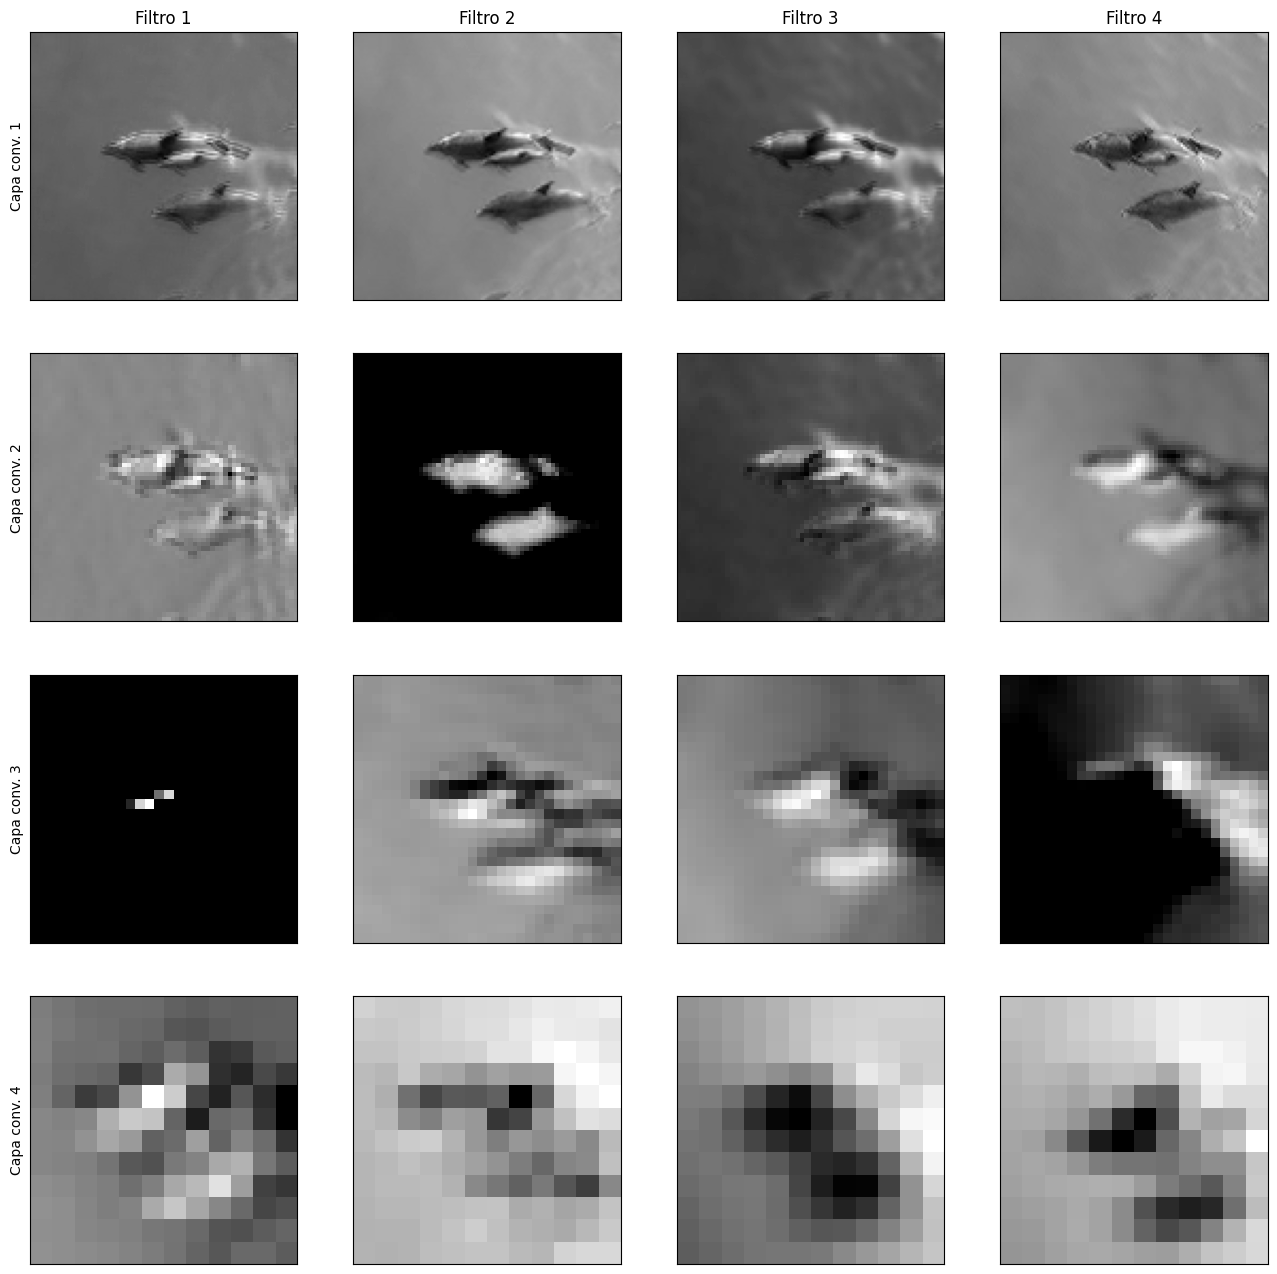

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

# Asumimos que tienes un modelo llamado 'modelo' y que conv_layers son las capas convolucionales
conv_layers = [layer for layer in model.layers if 'conv' in layer.name]  # Extrae las capas convolucionales

# Crear subplots para visualizar los mapas de características
_, axes = plt.subplots(len(conv_layers), 4, figsize=(16,16))

# Establecer una semilla aleatoria para obtener resultados consistentes
np.random.seed(1)

# Modelo que nos da las salidas de las capas convolucionales
vis_model = tf.keras.models.Model(
    inputs=model.inputs,  # Las entradas son las mismas del modelo original
    outputs=[layer.output for layer in conv_layers]  # Salidas de las capas convolucionales
)

# Seleccionar una imagen de prueba, aquí por ejemplo, usamos X_test[40]
imagen_prueba = np.expand_dims(X_test[40], axis=0)  # Expandir para formato de batch

# Obtener los mapas de características
feature_maps = vis_model.predict(imagen_prueba)

# Recorrer cada capa convolucional y sus mapas de características correspondientes
for i, f_map in enumerate(feature_maps):
    axes[i, 0].set_ylabel(f"Capa conv. {i+1}")  # Etiqueta de la capa en la fila correspondiente
    axes[0, i].set_title(f"Filtro {i+1}")  # Etiqueta de la columna

    # Filtrar los mapas de características que tengan activaciones
    f_map = f_map[:,:,:, np.any(f_map[0,:,:,:] > 0, axis=(0,1)) ]

    # Seleccionar 4 mapas de características aleatorios para mostrar
    sel = np.random.randint(0, f_map.shape[-1], 4)
    feature_map_selected = f_map[:,:,:, sel]  # Selección de 4 mapas
    feature_map_selected = feature_map_selected[0]  # Eliminar la dimensión del batch
    feature_map_selected = np.moveaxis(feature_map_selected, -1, 0)  # Reordenar ejes

    # Mostrar los 4 mapas seleccionados
    for j, image in enumerate(feature_map_selected):
        axes[i, j].imshow(image, cmap="gray")  # Visualización en escala de grises
        axes[i, j].set_xticks([])  # Eliminar ticks del eje X
        axes[i, j].set_yticks([])  # Eliminar ticks del eje Y

plt.show()


### NUMERAL C

Al finalizar la ejecución del código deben presentar la matriz de confusión obtenida, el
cálculo del valor de las métricas de desempeño Exactitud (Accuracy), Precisión,
Sensibilidad (Recall), f1-Score y analizar qué tan bueno es el clasificador de imágenes
obtenido.

121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 384ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step


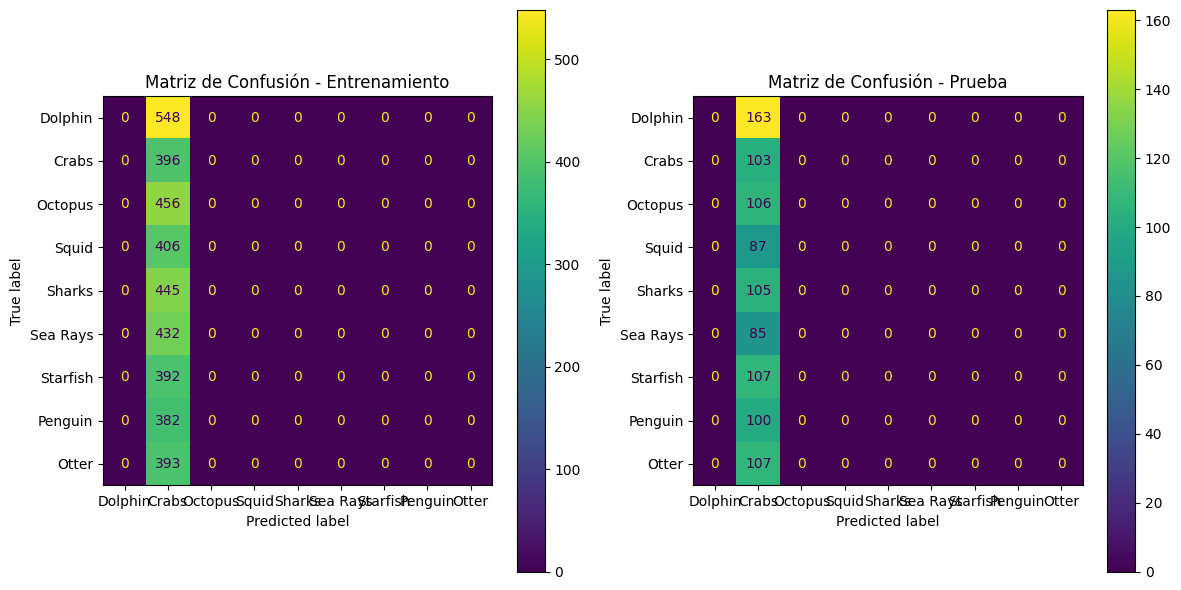

Informe de clasificación - Entrenamiento
              precision    recall  f1-score   support

     Dolphin       0.00      0.00      0.00       548
       Crabs       0.10      1.00      0.19       396
     Octopus       0.00      0.00      0.00       456
       Squid       0.00      0.00      0.00       406
      Sharks       0.00      0.00      0.00       445
    Sea Rays       0.00      0.00      0.00       432
    Starfish       0.00      0.00      0.00       392
     Penguin       0.00      0.00      0.00       382
       Otter       0.00      0.00      0.00       393

    accuracy                           0.10      3850
   macro avg       0.01      0.11      0.02      3850
weighted avg       0.01      0.10      0.02      3850

Informe de clasificación - Prueba
              precision    recall  f1-score   support

     Dolphin       0.00      0.00      0.00       163
       Crabs       0.11      1.00      0.19       103
     Octopus       0.00      0.00      0.00       106
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Convertir etiquetas de one-hot encoding a enteros
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Obtener predicciones para el conjunto de entrenamiento
y_pred_train = np.argmax(model.predict(X_train), axis=1)

# Obtener predicciones para el conjunto de prueba
y_pred_test = np.argmax(model.predict(X_test), axis=1)

# Graficar matrices de confusión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Matriz de confusión para el conjunto de entrenamiento
ConfusionMatrixDisplay.from_predictions(
    y_true=y_train_int,
    y_pred=y_pred_train,
    display_labels=clases,  # Aquí deberías tener tus clases (etiquetas)
    ax=ax1
)
ax1.set_title("Matriz de Confusión - Entrenamiento")

# Matriz de confusión para el conjunto de prueba
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test_int,
    y_pred=y_pred_test,
    display_labels=clases,
    ax=ax2
)
ax2.set_title("Matriz de Confusión - Prueba")

plt.tight_layout()
plt.show()

# Informe de clasificación para el conjunto de entrenamiento
print("Informe de clasificación - Entrenamiento")
print(classification_report(y_train_int, y_pred_train, target_names=clases))

# Informe de clasificación para el conjunto de prueba
print("Informe de clasificación - Prueba")
print(classification_report(y_test_int, y_pred_test, target_names=clases))

# Exactitud, Precisión, Recall y F1 para el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_int, y_pred_train)
precision_train = precision_score(y_train_int, y_pred_train, average='weighted')
recall_train = recall_score(y_train_int, y_pred_train, average='weighted')
f1_train = f1_score(y_train_int, y_pred_train, average='weighted')

print(f"\nMétricas - Entrenamiento:\n"
      f"Exactitud: {accuracy_train}\n"
      f"Precisión: {precision_train}\n"
      f"Recall: {recall_train}\n"
      f"F1-Score: {f1_train}")

# Exactitud, Precisión, Recall y F1 para el conjunto de prueba
accuracy_test = accuracy_score(y_test_int, y_pred_test)
precision_test = precision_score(y_test_int, y_pred_test, average='weighted')
recall_test = recall_score(y_test_int, y_pred_test, average='weighted')
f1_test = f1_score(y_test_int, y_pred_test, average='weighted')

print(f"\nMétricas - Prueba:\n"
      f"Exactitud: {accuracy_test}\n"
      f"Precisión: {precision_test}\n"
      f"Recall: {recall_test}\n"
      f"F1-Score: {f1_test}")


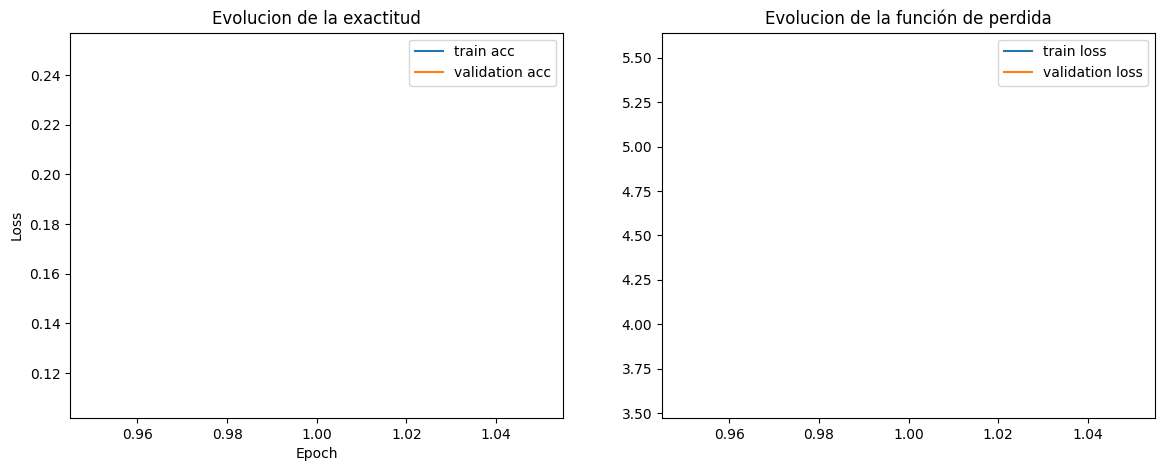

In [ ]:
#Graficar la evolución del accuracy y loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

#plot accuracy
ax1.plot(epochs, history["accuracy"], label ="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

#plot loss
ax2.plot(epochs, history["loss"], label ="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la función de perdida")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

plt.show()

## PREGUNTA 5

Utilice una CNN preentrenada tal como ResNet-50, ResNet-100, Xception,
Inception-ResNet-v2, etc. para la clasificación de razas de gatos, utilizando el mismo
Dataset de la CNN del punto 4. Analice los resultados obtenidos al comparar los
resultados de las métricas de desempeño Exactitud (Accuracy), Precisión, Sensibilidad
(Recall), f1-Score. Concluya sobre las ventajas en la utilización o no, de estas redes
preentrenadas.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.1373 - loss: 2.3187 - val_accuracy: 0.1862 - val_loss: 2.1984
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.1981 - loss: 2.1593 - val_accuracy: 0.1751 - val_loss: 2.1506
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.2320 - loss: 2.0815 - val_accuracy: 0.2553 - val_loss: 2.0607
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.2517 - loss: 2.0209 - val_accuracy: 0.2383 - val_loss: 2.0387
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.2851 - loss: 1.9668 - val_accuracy: 0.2681 - val_loss: 1.9933
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.2985 - loss: 1.9278 - val_accuracy: 0.3040 - val_loss: 1.9329
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.2911 - loss: 1.9305 - val_accuracy: 0.2707 - val_loss: 1.9923
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2

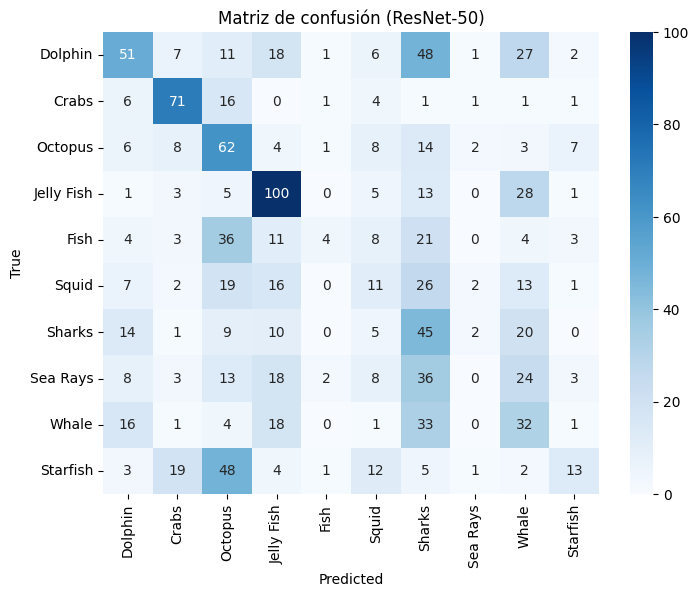

              precision    recall  f1-score   support

     Dolphin       0.44      0.30      0.35       172
       Crabs       0.60      0.70      0.65       102
     Octopus       0.28      0.54      0.37       115
  Jelly Fish       0.50      0.64      0.56       156
        Fish       0.40      0.04      0.08        94
       Squid       0.16      0.11      0.13        97
      Sharks       0.19      0.42      0.26       106
    Sea Rays       0.00      0.00      0.00       115
       Whale       0.21      0.30      0.25       106
    Starfish       0.41      0.12      0.19       108

    accuracy                           0.33      1171
   macro avg       0.32      0.32      0.28      1171
weighted avg       0.33      0.33      0.30      1171

Exactitud (Accuracy): 0.33219470538001705
Precisión (Precision): 0.32985612235586537
Sensibilidad (Recall): 0.33219470538001705
F1-Score: 0.2993655419095813


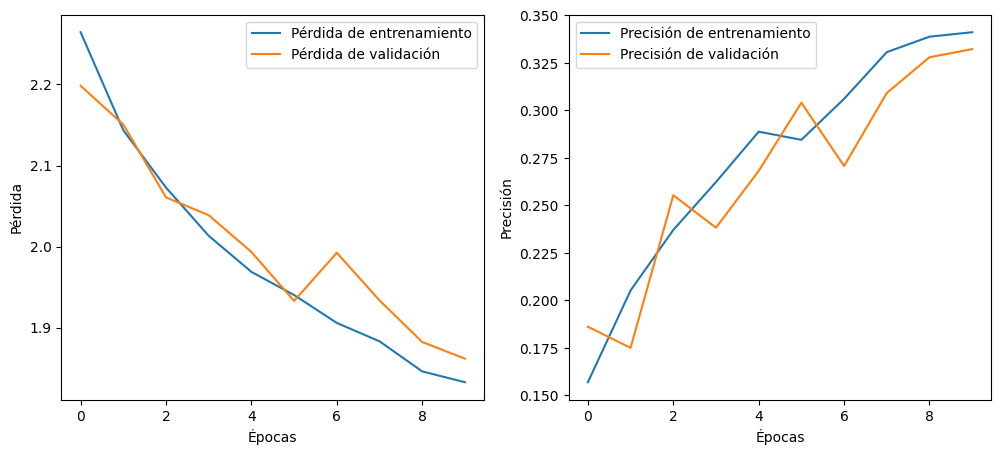

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Cargar el modelo preentrenado ResNet-50 sin las capas superiores
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Paso 2: Añadir capas adicionales para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Capa de pooling global
x = Dense(512, activation='relu')(x)  # Capa densa
predictions = Dense(len(class_names), activation='softmax')(x)  # Capa de salida

# Paso 3: Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Paso 4: Congelar las capas del modelo base (no entrenarlas)
for layer in base_model.layers:
    layer.trainable = False

# Paso 5: Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Paso 6: Entrenar el modelo con el conjunto de entrenamiento
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Paso 7: Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nPrecisión en el conjunto de prueba: {test_acc}")

# Paso 8: Obtener predicciones y calcular métricas
y_pred = np.argmax(model.predict(X_test), axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusión (ResNet-50)')
plt.show()

# Informe de clasificación: Precisión, Sensibilidad, F1-Score
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# Cálculo de métricas individuales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Exactitud (Accuracy): {accuracy}")
print(f"Precisión (Precision): {precision}")
print(f"Sensibilidad (Recall): {recall}")
print(f"F1-Score: {f1}")

# Graficar la evolución de la función de pérdida y la precisión
plt.figure(figsize=(12, 5))

# Graficar la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

#5. Entrenamiento del modelo con modelo preentrenado Resnet50

Se usa EfficienteB3 ya que logra un equilibrio óptimo entre la profundidad, el ancho y la resolución de la red, lo que permite un mejor rendimiento con menos parámetros en comparación con otros modelos, tambien en dataset pequeños como este tiende a generalizar mejor y evitar el sobreajuste y lo mas importante en este caso es eficiente en velocidad y uso de memoria lo que es crucial en entornos tan limitados como este.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [ ]:
base_model2 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)
base_model2.trainable = False
input = tf.keras.Input(shape=(128,128,3))
x = base_model2(input)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(160, activation='relu')(x)
output = tf.keras.layers.Dense(8, activation="softmax")(x)
transfer_learning_model2 = tf.keras.Model(input, output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
X_train = tf.keras.applications.resnet50.preprocess_input(
    X_train, data_format=None
)
X_test = tf.keras.applications.resnet50.preprocess_input(
    X_test, data_format=None
)

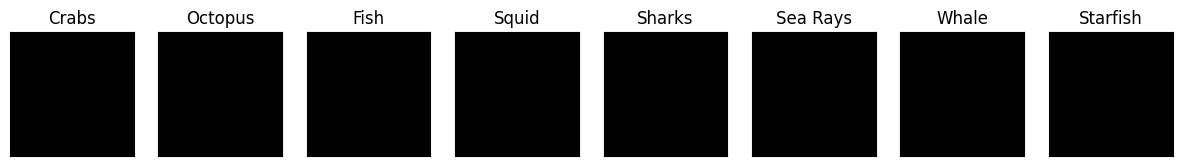

In [ ]:
_, axes = plt.subplots(1, 8, figsize=(15,15))
for i in range(len(clases)):
    # Find the indices where y_train == i
    indices = np.where(y_train[:, i] == 1)[0]
    # Use the first index from the result to get the image
    axes[i].imshow(X_train[indices[0]])
    axes[i].set_title(clases[i])

    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()




In [ ]:
transfer_learning_model2.compile(optimizer="adam",
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
# # Convertir las etiquetas a one-hot encoding
# y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=8)
# y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=8)

# # Convertir las etiquetas a one-hot encoding
# y_train = to_categorical(y_train, num_classes=8)
# y_test = to_categorical(y_test, num_classes=8)

history = transfer_learning_model2.fit(
    train_datagen.flow(X_train, y_train, subset="training"),
    validation_data = train_datagen.flow(X_train, y_train, subset="validation"),
    epochs = 1,
    callbacks = callbacks,
    batch_size = 32,
    validation_batch_size = 32
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1958 - loss: 1.9958
Epoch 1: val_loss did not improve from 5.26693
85/85 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.1962 - loss: 1.9949 - val_accuracy: 0.1376 - val_loss: 18.4486 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

def create_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, stratify=y)

In [ ]:
input_shape = (128, 128, 3)
num_classes = 8

# Create model
model_vgg16 = create_vgg16_model(input_shape, num_classes)

# Train model
history_vgg16 = model_vgg16.fit(
    train_datagen.flow(X_train, y_train, subset="training"),
    epochs=1,
    validation_data = train_datagen.flow(X_train, y_train, subset="validation"),
    callbacks=callbacks
)



85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1220 - loss: 2.2392
Epoch 1: val_loss improved from 5.26693 to 2.10735, saving model to model_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 804s 9s/step - accuracy: 0.1220 - loss: 2.2385 - val_accuracy: 0.1391 - val_loss: 2.1073 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


#Graficos

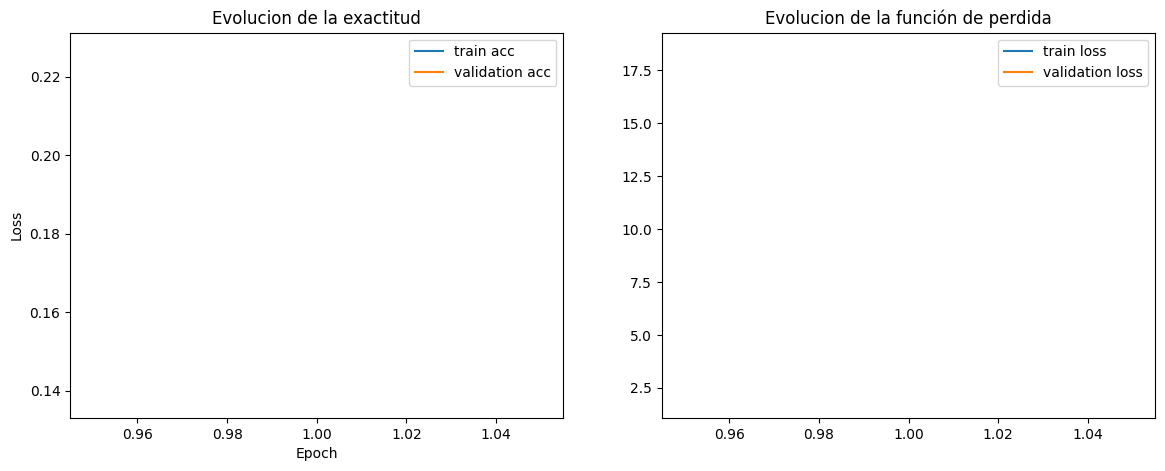

In [ ]:
#Graficar la evolución del accuracy y loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

#history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

#plot accuracy
ax1.plot(epochs, history["accuracy"], label ="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

#plot loss
ax2.plot(epochs, history["loss"], label ="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la función de perdida")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

plt.show()

###Mtraiz de confusión y métricas

Forma inicial de x_train: (3380, 128, 128, 3)
Forma inicial de x_test: (846, 128, 128, 3)
Forma de x_train después de expansión: (3380, 128, 128, 3)
Forma de x_test después de expansión: (846, 128, 128, 3)
106/106 ━━━━━━━━━━━━━━━━━━━━ 101s 899ms/step - accuracy: 0.1469 - loss: 2.0760

Entrenamiento y validación: 

106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step
              precision    recall  f1-score   support

           0       0.20      0.00      0.01       372
           1       0.23      0.36      0.28       456
           2       0.00      0.00      0.00       377
           3       0.00      0.00      0.00       411
           4       0.28      0.76      0.41       458
           5       0.00      0.00      0.00       433
           6       0.47      0.16      0.24       467
           7       0.25      0.77      0.38       406

    accuracy                           0.27      3380
   macro avg       0.18      0.26      0.16      3380
weighted avg       0.19      0.27      0.17 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

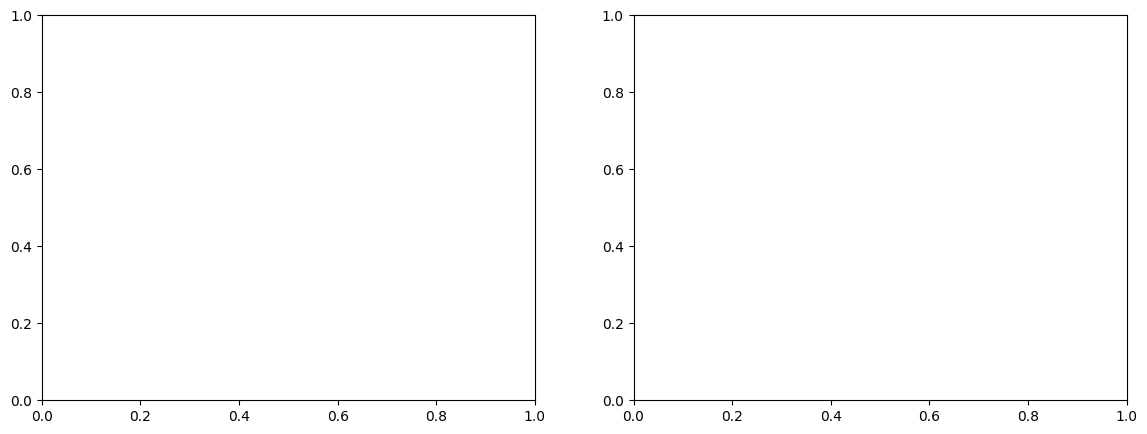

In [ ]:
# Imprime la forma inicial de los datos
print(f"Forma inicial de x_train: {X_train.shape}")
print(f"Forma inicial de x_test: {X_test.shape}")

# Añadir la dimensión del canal si es necesario
if len(X_train.shape) == 3:  # Si x_train tiene la forma (batch_size, 28, 28)
    x_train = np.expand_dims(X_train, axis=-1)  # Cambia a (batch_size, 28, 28, 1)
if len(X_test.shape) == 3:  # Si x_test tiene la forma (batch_size, 28, 28)
    x_test = np.expand_dims(X_test, axis=-1)  # Cambia a (batch_size, 28, 28, 1)

# Imprime la forma de los datos después de la expansión
print(f"Forma de x_train después de expansión: {X_train.shape}")
print(f"Forma de x_test después de expansión: {X_test.shape}")

# Define the model_CNN
# Import the necessary libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model_CNN = Sequential(
    [
        keras.Input(shape=X_train.shape[1:]),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(8, activation="softmax"),
    ]
)
# Compile the model
model_CNN.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

#Fit the model
model_CNN.fit(X_train, y_train, epochs=1)

# Matriz de confusión y métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

print('\nEntrenamiento y validación: \n')

# Predicciones para el conjunto de entrenamiento
y_pred_train = model_CNN.predict(X_train)

# Assuming y_train is one-hot encoded, convert to class labels
y_train_labels = np.argmax(y_train, axis=1)  # Convert y_train to multiclass format
y_pred_train_labels = np.argmax(y_pred_train, axis=1)  # Convert to class labels


# Use y_train_labels (multiclass) instead of y_train (multilabel-indicator)
print(classification_report(y_train_labels, y_pred_train_labels))

ConfusionMatrixDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_pred_train,
    display_labels=clases,
    ax=ax1
)
ax1.set_title("Entrenamiento y validación")

print('\nPrueba: \n')

# Predicciones para el conjunto de prueba
y_pred_test = np.argmax(model_CNN.predict(X_test), axis=1)

print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_test,
    display_labels=clases,
    ax=ax2
)
ax2.set_title("Prueba")

plt.show()

#Conclusiones